In [1]:
import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Reshape, Flatten
from tensorflow.keras.layers import Conv1D, TimeDistributed, UpSampling1D, MaxPooling1D
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model

### Some global variables

In [2]:
Rnum = 1000
x = np.linspace(0.0,1.0,num=128)
dx = 1.0/np.shape(x)[0]
tsteps = np.linspace(0.0,2.0,num=400)
dt = 2.0/np.shape(tsteps)[0]
mode = 'train'

### Functions for full-order snapshots of Burgers Equation

In [3]:
def exact_solution(Rnum,t):
    t0 = np.exp(Rnum/8.0)

    return (x/(t+1))/(1.0+np.sqrt((t+1)/t0)*np.exp(Rnum*(x*x)/(4.0*t+4)))

def collect_snapshots(Rnum):
    snapshot_matrix = np.zeros(shape=(np.shape(x)[0],np.shape(tsteps)[0]))

    trange = np.arange(np.shape(tsteps)[0])
    for t in trange:
        snapshot_matrix[:,t] = exact_solution(Rnum,tsteps[t])[:]

    return np.transpose(snapshot_matrix)

### Collect some snapshot data for CNN-LSTM embedding

In [4]:
snapshots_train = collect_snapshots(Rnum)
snapshots_train = np.expand_dims(snapshots_train,-1)

### Do some shifting for evolution predictions

In [5]:
snapshots_evolve = snapshots_train[1:]
snapshots_train = snapshots_train[0:-1]

### ML related presets

In [6]:
weights_filepath = 'best_weights.h5'
lrate = 0.001

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Autoencoder and LSTM

In [7]:
# Encoder
encoder_inputs = Input(shape=(128,1),name='Field')

x = Conv1D(25,kernel_size=3,activation='swish',padding='same')(encoder_inputs)
enc_l2 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(15,kernel_size=3,activation='swish',padding='same')(enc_l2)
enc_l3 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(10,kernel_size=3,activation='swish',padding='same')(enc_l3)
enc_l4 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(5,kernel_size=3,activation='swish',padding='same')(enc_l4)
enc_l5 = MaxPooling1D(2,padding='same')(x)

x = Flatten()(enc_l5)
x = Dense(8,activation='swish')(x)
x = Dense(4,activation='swish')(x)
encoded = Dense(2,activation='linear')(x)

# LSTM
lstm_inputs = Reshape((1,2))(encoded)
x = LSTM(40,return_sequences=True)(lstm_inputs)
lstm_outputs = Dense(2,activation=None)(x)

# Decoder architecture (shared)
dec_layer_1 = Flatten()
dec_layer_2 = Dense(2,activation='swish')
dec_layer_3 = Dense(4,activation='swish')
dec_layer_4 = Dense(8,activation='linear')
dec_layer_5 = Reshape((8,1))

dec_layer_6 = Conv1D(5,kernel_size=3,activation='swish',padding='same')
dec_layer_7 = Conv1D(10,kernel_size=3,activation='swish',padding='same')
dec_layer_8 = Conv1D(15,kernel_size=3,activation='swish',padding='same')
dec_layer_9 = Conv1D(20,kernel_size=3,activation='swish',padding='same')
dec_layer_10 = Conv1D(1,kernel_size=3,activation=None,padding='same')

# Decoder - using LSTM
x = dec_layer_1(lstm_outputs)
x = dec_layer_2(x)
x = dec_layer_3(x)
x = dec_layer_4(x)
x = dec_layer_5(x)

x = dec_layer_6(x)
x = UpSampling1D(2)(x)

x = dec_layer_7(x)
x = UpSampling1D(2)(x)

x = dec_layer_8(x)
x = UpSampling1D(2)(x)

x = dec_layer_9(x)
x = UpSampling1D(2)(x)

lstm_decoder_outputs = dec_layer_10(x)

# Decoder - using AE only
x = dec_layer_1(encoded)
x = dec_layer_2(x)
x = dec_layer_3(x)
x = dec_layer_4(x)
x = dec_layer_5(x)

x = dec_layer_6(x)
x = UpSampling1D(2)(x)

x = dec_layer_7(x)
x = UpSampling1D(2)(x)

x = dec_layer_8(x)
x = UpSampling1D(2)(x)

x = dec_layer_9(x)
x = UpSampling1D(2)(x)

ae_decoder_outputs = dec_layer_10(x)

# Compile model
model = Model(inputs=[encoder_inputs],outputs=[ae_decoder_outputs,lstm_decoder_outputs],name='CAE-LSTM')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination],loss_weights=[1.0,1.0])    
model.summary()

num_epochs = 500
batch_size = 4

if mode == 'train':
    train_history = model.fit(x=snapshots_train, 
                              y=[snapshots_train,snapshots_evolve], 
                              epochs=num_epochs, 
                              batch_size=batch_size, 
                              callbacks=callbacks_list,
                              validation_split=0.1)

Model: "CAE-LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 25)      100         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 64, 25)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64, 15)       1140        max_pooling1d[0][0]              
___________________________________________________________________________________________

84/90 [===========================>..] - ETA: 0s - loss: 0.0265 - conv1d_8_loss: 0.0133 - conv1d_8_1_loss: 0.0133 - conv1d_8_coeff_determination: -1914161.5000 - conv1d_8_1_coeff_determination: -1934249.0000
Epoch 00001: loss improved from inf to 0.02566, saving model to best_weights.h5
90/90 [==============================] - 1s 11ms/step - loss: 0.0257 - conv1d_8_loss: 0.0128 - conv1d_8_1_loss: 0.0128 - conv1d_8_coeff_determination: -1786550.7500 - conv1d_8_1_coeff_determination: -1805299.0000 - val_loss: 0.0191 - val_conv1d_8_loss: 0.0094 - val_conv1d_8_1_loss: 0.0097 - val_conv1d_8_coeff_determination: -0.4154 - val_conv1d_8_1_coeff_determination: -0.4097
Epoch 2/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0117 - conv1d_8_loss: 0.0056 - conv1d_8_1_loss: 0.0061 - conv1d_8_coeff_determination: 0.3570 - conv1d_8_1_coeff_determination: 0.2771
Epoch 00002: loss improved from 0.02566 to 0.01134, saving model to best_weights.h5
90/90 [==============================] - 0

Epoch 14/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0025 - conv1d_8_loss: 0.0012 - conv1d_8_1_loss: 0.0012 - conv1d_8_coeff_determination: 0.9087 - conv1d_8_1_coeff_determination: 0.9081
Epoch 00014: loss improved from 0.00251 to 0.00247, saving model to best_weights.h5
90/90 [==============================] - 0s 4ms/step - loss: 0.0025 - conv1d_8_loss: 0.0012 - conv1d_8_1_loss: 0.0012 - conv1d_8_coeff_determination: 0.9088 - conv1d_8_1_coeff_determination: 0.9081 - val_loss: 0.0048 - val_conv1d_8_loss: 0.0023 - val_conv1d_8_1_loss: 0.0025 - val_conv1d_8_coeff_determination: 0.7374 - val_conv1d_8_1_coeff_determination: 0.7197
Epoch 15/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0024 - conv1d_8_loss: 0.0012 - conv1d_8_1_loss: 0.0012 - conv1d_8_coeff_determination: 0.9121 - conv1d_8_1_coeff_determination: 0.9116
Epoch 00015: loss improved from 0.00247 to 0.00239, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - 

86/90 [===========================>..] - ETA: 0s - loss: 7.3542e-04 - conv1d_8_loss: 3.6603e-04 - conv1d_8_1_loss: 3.6939e-04 - conv1d_8_coeff_determination: 0.9742 - conv1d_8_1_coeff_determination: 0.9739
Epoch 00038: loss did not improve from 0.00072
90/90 [==============================] - 0s 5ms/step - loss: 7.4103e-04 - conv1d_8_loss: 3.6898e-04 - conv1d_8_1_loss: 3.7206e-04 - conv1d_8_coeff_determination: 0.9741 - conv1d_8_1_coeff_determination: 0.9738 - val_loss: 0.0039 - val_conv1d_8_loss: 0.0019 - val_conv1d_8_1_loss: 0.0020 - val_conv1d_8_coeff_determination: 0.8005 - val_conv1d_8_1_coeff_determination: 0.7938
Epoch 39/500
81/90 [==========================>...] - ETA: 0s - loss: 6.8624e-04 - conv1d_8_loss: 3.4382e-04 - conv1d_8_1_loss: 3.4242e-04 - conv1d_8_coeff_determination: 0.9760 - conv1d_8_1_coeff_determination: 0.9761
Epoch 00039: loss improved from 0.00072 to 0.00068, saving model to best_weights.h5
90/90 [==============================] - 0s 6ms/step - loss: 6.8070e-

90/90 [==============================] - 0s 3ms/step - loss: 5.2171e-04 - conv1d_8_loss: 2.6208e-04 - conv1d_8_1_loss: 2.5962e-04 - conv1d_8_coeff_determination: 0.9821 - conv1d_8_1_coeff_determination: 0.9821 - val_loss: 0.0032 - val_conv1d_8_loss: 0.0016 - val_conv1d_8_1_loss: 0.0016 - val_conv1d_8_coeff_determination: 0.8299 - val_conv1d_8_1_coeff_determination: 0.8282
Epoch 51/500
86/90 [===========================>..] - ETA: 0s - loss: 5.0313e-04 - conv1d_8_loss: 2.5249e-04 - conv1d_8_1_loss: 2.5064e-04 - conv1d_8_coeff_determination: 0.9826 - conv1d_8_1_coeff_determination: 0.9826
Epoch 00051: loss improved from 0.00052 to 0.00050, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 5.0076e-04 - conv1d_8_loss: 2.5136e-04 - conv1d_8_1_loss: 2.4941e-04 - conv1d_8_coeff_determination: 0.9827 - conv1d_8_1_coeff_determination: 0.9827 - val_loss: 0.0033 - val_conv1d_8_loss: 0.0016 - val_conv1d_8_1_loss: 0.0016 - val_conv1d_8_coeff_determination:

Epoch 63/500
89/90 [============================>.] - ETA: 0s - loss: 3.8520e-04 - conv1d_8_loss: 1.9296e-04 - conv1d_8_1_loss: 1.9224e-04 - conv1d_8_coeff_determination: 0.9868 - conv1d_8_1_coeff_determination: 0.9868
Epoch 00063: loss improved from 0.00039 to 0.00038, saving model to best_weights.h5
90/90 [==============================] - 1s 6ms/step - loss: 3.8458e-04 - conv1d_8_loss: 1.9260e-04 - conv1d_8_1_loss: 1.9198e-04 - conv1d_8_coeff_determination: 0.9868 - conv1d_8_1_coeff_determination: 0.9868 - val_loss: 0.0024 - val_conv1d_8_loss: 0.0012 - val_conv1d_8_1_loss: 0.0012 - val_conv1d_8_coeff_determination: 0.8620 - val_conv1d_8_1_coeff_determination: 0.8607
Epoch 64/500
85/90 [===========================>..] - ETA: 0s - loss: 3.7120e-04 - conv1d_8_loss: 1.8628e-04 - conv1d_8_1_loss: 1.8492e-04 - conv1d_8_coeff_determination: 0.9873 - conv1d_8_1_coeff_determination: 0.9873
Epoch 00064: loss improved from 0.00038 to 0.00037, saving model to best_weights.h5
90/90 [============

Epoch 88/500
87/90 [============================>.] - ETA: 0s - loss: 2.1072e-04 - conv1d_8_loss: 1.0094e-04 - conv1d_8_1_loss: 1.0977e-04 - conv1d_8_coeff_determination: 0.9932 - conv1d_8_1_coeff_determination: 0.9926
Epoch 00088: loss did not improve from 0.00018
90/90 [==============================] - 1s 6ms/step - loss: 2.1177e-04 - conv1d_8_loss: 1.0157e-04 - conv1d_8_1_loss: 1.1020e-04 - conv1d_8_coeff_determination: 0.9931 - conv1d_8_1_coeff_determination: 0.9926 - val_loss: 0.0024 - val_conv1d_8_loss: 0.0011 - val_conv1d_8_1_loss: 0.0012 - val_conv1d_8_coeff_determination: 0.8610 - val_conv1d_8_1_coeff_determination: 0.8538
Epoch 89/500
87/90 [============================>.] - ETA: 0s - loss: 1.7143e-04 - conv1d_8_loss: 8.5378e-05 - conv1d_8_1_loss: 8.6049e-05 - conv1d_8_coeff_determination: 0.9942 - conv1d_8_1_coeff_determination: 0.9941
Epoch 00089: loss improved from 0.00018 to 0.00017, saving model to best_weights.h5
90/90 [==============================] - 1s 6ms/step - l

90/90 [==============================] - 1s 6ms/step - loss: 1.1297e-04 - conv1d_8_loss: 5.6279e-05 - conv1d_8_1_loss: 5.6694e-05 - conv1d_8_coeff_determination: 0.9962 - conv1d_8_1_coeff_determination: 0.9962 - val_loss: 0.0015 - val_conv1d_8_loss: 7.1450e-04 - val_conv1d_8_1_loss: 7.7001e-04 - val_conv1d_8_coeff_determination: 0.9183 - val_conv1d_8_1_coeff_determination: 0.9120
Epoch 101/500
89/90 [============================>.] - ETA: 0s - loss: 1.5882e-04 - conv1d_8_loss: 7.6972e-05 - conv1d_8_1_loss: 8.1845e-05 - conv1d_8_coeff_determination: 0.9948 - conv1d_8_1_coeff_determination: 0.9944
Epoch 00101: loss did not improve from 0.00011
90/90 [==============================] - 1s 6ms/step - loss: 1.5944e-04 - conv1d_8_loss: 7.7332e-05 - conv1d_8_1_loss: 8.2105e-05 - conv1d_8_coeff_determination: 0.9947 - conv1d_8_1_coeff_determination: 0.9944 - val_loss: 0.0019 - val_conv1d_8_loss: 9.2018e-04 - val_conv1d_8_1_loss: 0.0010 - val_conv1d_8_coeff_determination: 0.8958 - val_conv1d_8_1

Epoch 113/500
86/90 [===========================>..] - ETA: 0s - loss: 9.3718e-05 - conv1d_8_loss: 4.5771e-05 - conv1d_8_1_loss: 4.7947e-05 - conv1d_8_coeff_determination: 0.9969 - conv1d_8_1_coeff_determination: 0.9968
Epoch 00113: loss did not improve from 0.00008
90/90 [==============================] - 0s 5ms/step - loss: 9.4708e-05 - conv1d_8_loss: 4.6381e-05 - conv1d_8_1_loss: 4.8327e-05 - conv1d_8_coeff_determination: 0.9968 - conv1d_8_1_coeff_determination: 0.9967 - val_loss: 0.0016 - val_conv1d_8_loss: 7.6183e-04 - val_conv1d_8_1_loss: 8.2128e-04 - val_conv1d_8_coeff_determination: 0.9105 - val_conv1d_8_1_coeff_determination: 0.9038
Epoch 114/500
79/90 [=========================>....] - ETA: 0s - loss: 1.0048e-04 - conv1d_8_loss: 4.8211e-05 - conv1d_8_1_loss: 5.2268e-05 - conv1d_8_coeff_determination: 0.9967 - conv1d_8_1_coeff_determination: 0.9964
Epoch 00114: loss did not improve from 0.00008
90/90 [==============================] - 0s 4ms/step - loss: 1.0196e-04 - conv1d_8_

Epoch 126/500
84/90 [===========================>..] - ETA: 0s - loss: 5.9468e-05 - conv1d_8_loss: 2.9279e-05 - conv1d_8_1_loss: 3.0189e-05 - conv1d_8_coeff_determination: 0.9980 - conv1d_8_1_coeff_determination: 0.9980
Epoch 00126: loss did not improve from 0.00006
90/90 [==============================] - 0s 5ms/step - loss: 6.0605e-05 - conv1d_8_loss: 2.9775e-05 - conv1d_8_1_loss: 3.0830e-05 - conv1d_8_coeff_determination: 0.9980 - conv1d_8_1_coeff_determination: 0.9979 - val_loss: 0.0012 - val_conv1d_8_loss: 5.7546e-04 - val_conv1d_8_1_loss: 6.2923e-04 - val_conv1d_8_coeff_determination: 0.9327 - val_conv1d_8_1_coeff_determination: 0.9266
Epoch 127/500
82/90 [==========================>...] - ETA: 0s - loss: 5.5858e-05 - conv1d_8_loss: 2.7746e-05 - conv1d_8_1_loss: 2.8112e-05 - conv1d_8_coeff_determination: 0.9981 - conv1d_8_1_coeff_determination: 0.9981
Epoch 00127: loss improved from 0.00006 to 0.00005, saving model to best_weights.h5
90/90 [==============================] - 0s 6m

Epoch 139/500
88/90 [============================>.] - ETA: 0s - loss: 4.3462e-05 - conv1d_8_loss: 2.1517e-05 - conv1d_8_1_loss: 2.1945e-05 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.9985
Epoch 00139: loss improved from 0.00005 to 0.00004, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 4.3397e-05 - conv1d_8_loss: 2.1490e-05 - conv1d_8_1_loss: 2.1907e-05 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.9985 - val_loss: 0.0011 - val_conv1d_8_loss: 5.3820e-04 - val_conv1d_8_1_loss: 5.8132e-04 - val_conv1d_8_coeff_determination: 0.9392 - val_conv1d_8_1_coeff_determination: 0.9344
Epoch 140/500
85/90 [===========================>..] - ETA: 0s - loss: 4.7106e-05 - conv1d_8_loss: 2.3291e-05 - conv1d_8_1_loss: 2.3815e-05 - conv1d_8_coeff_determination: 0.9984 - conv1d_8_1_coeff_determination: 0.9984
Epoch 00140: loss did not improve from 0.00004
90/90 [==============================] - 0s 5m

Epoch 152/500
83/90 [==========================>...] - ETA: 0s - loss: 3.9727e-05 - conv1d_8_loss: 1.9375e-05 - conv1d_8_1_loss: 2.0352e-05 - conv1d_8_coeff_determination: 0.9987 - conv1d_8_1_coeff_determination: 0.9986
Epoch 00152: loss improved from 0.00004 to 0.00004, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 3.8903e-05 - conv1d_8_loss: 1.9002e-05 - conv1d_8_1_loss: 1.9901e-05 - conv1d_8_coeff_determination: 0.9987 - conv1d_8_1_coeff_determination: 0.9987 - val_loss: 0.0011 - val_conv1d_8_loss: 5.4244e-04 - val_conv1d_8_1_loss: 5.9319e-04 - val_conv1d_8_coeff_determination: 0.9382 - val_conv1d_8_1_coeff_determination: 0.9325
Epoch 153/500
84/90 [===========================>..] - ETA: 0s - loss: 3.2057e-05 - conv1d_8_loss: 1.5891e-05 - conv1d_8_1_loss: 1.6166e-05 - conv1d_8_coeff_determination: 0.9989 - conv1d_8_1_coeff_determination: 0.9989
Epoch 00153: loss improved from 0.00004 to 0.00003, saving model to best_weights.h5
90/90 [==

Epoch 165/500
86/90 [===========================>..] - ETA: 0s - loss: 4.3167e-05 - conv1d_8_loss: 2.0622e-05 - conv1d_8_1_loss: 2.2545e-05 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.9985
Epoch 00165: loss did not improve from 0.00003
90/90 [==============================] - 0s 5ms/step - loss: 4.2844e-05 - conv1d_8_loss: 2.0534e-05 - conv1d_8_1_loss: 2.2310e-05 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.9985 - val_loss: 0.0011 - val_conv1d_8_loss: 5.2936e-04 - val_conv1d_8_1_loss: 5.7665e-04 - val_conv1d_8_coeff_determination: 0.9411 - val_conv1d_8_1_coeff_determination: 0.9360
Epoch 166/500
80/90 [=========================>....] - ETA: 0s - loss: 3.5439e-05 - conv1d_8_loss: 1.7182e-05 - conv1d_8_1_loss: 1.8258e-05 - conv1d_8_coeff_determination: 0.9988 - conv1d_8_1_coeff_determination: 0.9988
Epoch 00166: loss did not improve from 0.00003
90/90 [==============================] - 0s 4ms/step - loss: 3.4579e-05 - conv1d_8_

Epoch 178/500
83/90 [==========================>...] - ETA: 0s - loss: 3.3336e-05 - conv1d_8_loss: 1.6034e-05 - conv1d_8_1_loss: 1.7303e-05 - conv1d_8_coeff_determination: 0.9989 - conv1d_8_1_coeff_determination: 0.9988
Epoch 00178: loss did not improve from 0.00003
90/90 [==============================] - 0s 5ms/step - loss: 3.3958e-05 - conv1d_8_loss: 1.6304e-05 - conv1d_8_1_loss: 1.7654e-05 - conv1d_8_coeff_determination: 0.9989 - conv1d_8_1_coeff_determination: 0.9988 - val_loss: 0.0012 - val_conv1d_8_loss: 5.7153e-04 - val_conv1d_8_1_loss: 6.0930e-04 - val_conv1d_8_coeff_determination: 0.9353 - val_conv1d_8_1_coeff_determination: 0.9310
Epoch 179/500
87/90 [============================>.] - ETA: 0s - loss: 3.9247e-05 - conv1d_8_loss: 1.8453e-05 - conv1d_8_1_loss: 2.0795e-05 - conv1d_8_coeff_determination: 0.9988 - conv1d_8_1_coeff_determination: 0.9986
Epoch 00179: loss did not improve from 0.00003
90/90 [==============================] - 0s 5ms/step - loss: 3.9300e-05 - conv1d_8_

Epoch 191/500
90/90 [==============================] - ETA: 0s - loss: 3.0092e-05 - conv1d_8_loss: 1.4398e-05 - conv1d_8_1_loss: 1.5695e-05 - conv1d_8_coeff_determination: 0.9990 - conv1d_8_1_coeff_determination: 0.9989
Epoch 00191: loss did not improve from 0.00002
90/90 [==============================] - 0s 5ms/step - loss: 3.0092e-05 - conv1d_8_loss: 1.4398e-05 - conv1d_8_1_loss: 1.5695e-05 - conv1d_8_coeff_determination: 0.9990 - conv1d_8_1_coeff_determination: 0.9989 - val_loss: 0.0011 - val_conv1d_8_loss: 5.4639e-04 - val_conv1d_8_1_loss: 5.9053e-04 - val_conv1d_8_coeff_determination: 0.9384 - val_conv1d_8_1_coeff_determination: 0.9335
Epoch 192/500
90/90 [==============================] - ETA: 0s - loss: 2.1922e-05 - conv1d_8_loss: 1.0826e-05 - conv1d_8_1_loss: 1.1097e-05 - conv1d_8_coeff_determination: 0.9993 - conv1d_8_1_coeff_determination: 0.9992
Epoch 00192: loss improved from 0.00002 to 0.00002, saving model to best_weights.h5
90/90 [==============================] - 0s 5m

Epoch 204/500
78/90 [=========================>....] - ETA: 0s - loss: 8.1085e-05 - conv1d_8_loss: 3.6785e-05 - conv1d_8_1_loss: 4.4299e-05 - conv1d_8_coeff_determination: 0.9975 - conv1d_8_1_coeff_determination: 0.9969
Epoch 00204: loss did not improve from 0.00002
90/90 [==============================] - 0s 4ms/step - loss: 7.3190e-05 - conv1d_8_loss: 3.3313e-05 - conv1d_8_1_loss: 3.9877e-05 - conv1d_8_coeff_determination: 0.9977 - conv1d_8_1_coeff_determination: 0.9972 - val_loss: 0.0011 - val_conv1d_8_loss: 5.1634e-04 - val_conv1d_8_1_loss: 5.5211e-04 - val_conv1d_8_coeff_determination: 0.9419 - val_conv1d_8_1_coeff_determination: 0.9378
Epoch 205/500
78/90 [=========================>....] - ETA: 0s - loss: 1.8421e-05 - conv1d_8_loss: 9.1123e-06 - conv1d_8_1_loss: 9.3088e-06 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00205: loss improved from 0.00002 to 0.00002, saving model to best_weights.h5
90/90 [==============================] - 0s 5m

Epoch 217/500
84/90 [===========================>..] - ETA: 0s - loss: 1.6834e-05 - conv1d_8_loss: 8.2915e-06 - conv1d_8_1_loss: 8.5428e-06 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00217: loss improved from 0.00002 to 0.00002, saving model to best_weights.h5
90/90 [==============================] - 0s 4ms/step - loss: 1.6953e-05 - conv1d_8_loss: 8.3459e-06 - conv1d_8_1_loss: 8.6070e-06 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9994 - val_loss: 0.0011 - val_conv1d_8_loss: 5.2542e-04 - val_conv1d_8_1_loss: 5.7123e-04 - val_conv1d_8_coeff_determination: 0.9398 - val_conv1d_8_1_coeff_determination: 0.9346
Epoch 218/500
85/90 [===========================>..] - ETA: 0s - loss: 1.8831e-05 - conv1d_8_loss: 9.3030e-06 - conv1d_8_1_loss: 9.5284e-06 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00218: loss did not improve from 0.00002
90/90 [==============================] - 0s 4m

Epoch 230/500
89/90 [============================>.] - ETA: 0s - loss: 1.9899e-05 - conv1d_8_loss: 9.6471e-06 - conv1d_8_1_loss: 1.0252e-05 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9993
Epoch 00230: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.9949e-05 - conv1d_8_loss: 9.6707e-06 - conv1d_8_1_loss: 1.0279e-05 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9993 - val_loss: 8.7370e-04 - val_conv1d_8_loss: 4.2172e-04 - val_conv1d_8_1_loss: 4.5198e-04 - val_conv1d_8_coeff_determination: 0.9524 - val_conv1d_8_1_coeff_determination: 0.9490
Epoch 231/500
78/90 [=========================>....] - ETA: 0s - loss: 2.1629e-05 - conv1d_8_loss: 1.0287e-05 - conv1d_8_1_loss: 1.1342e-05 - conv1d_8_coeff_determination: 0.9993 - conv1d_8_1_coeff_determination: 0.9993
Epoch 00231: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 2.1101e-05 - conv1

Epoch 243/500
90/90 [==============================] - ETA: 0s - loss: 1.7881e-05 - conv1d_8_loss: 8.5974e-06 - conv1d_8_1_loss: 9.2835e-06 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00243: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.7881e-05 - conv1d_8_loss: 8.5974e-06 - conv1d_8_1_loss: 9.2835e-06 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9994 - val_loss: 0.0011 - val_conv1d_8_loss: 5.3681e-04 - val_conv1d_8_1_loss: 5.7966e-04 - val_conv1d_8_coeff_determination: 0.9383 - val_conv1d_8_1_coeff_determination: 0.9334
Epoch 244/500
89/90 [============================>.] - ETA: 0s - loss: 1.8092e-05 - conv1d_8_loss: 8.7062e-06 - conv1d_8_1_loss: 9.3860e-06 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00244: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.8153e-05 - conv1d_8_

Epoch 256/500
85/90 [===========================>..] - ETA: 0s - loss: 1.6876e-05 - conv1d_8_loss: 8.0495e-06 - conv1d_8_1_loss: 8.8264e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00256: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.7057e-05 - conv1d_8_loss: 8.1373e-06 - conv1d_8_1_loss: 8.9198e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9994 - val_loss: 0.0010 - val_conv1d_8_loss: 5.0014e-04 - val_conv1d_8_1_loss: 5.3093e-04 - val_conv1d_8_coeff_determination: 0.9425 - val_conv1d_8_1_coeff_determination: 0.9389
Epoch 257/500
82/90 [==========================>...] - ETA: 0s - loss: 5.7346e-05 - conv1d_8_loss: 2.5341e-05 - conv1d_8_1_loss: 3.2005e-05 - conv1d_8_coeff_determination: 0.9984 - conv1d_8_1_coeff_determination: 0.9980
Epoch 00257: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 5.9506e-05 - conv1d_8_

Epoch 269/500
85/90 [===========================>..] - ETA: 0s - loss: 1.4089e-05 - conv1d_8_loss: 6.8214e-06 - conv1d_8_1_loss: 7.2672e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9995
Epoch 00269: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.4065e-05 - conv1d_8_loss: 6.8268e-06 - conv1d_8_1_loss: 7.2383e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9995 - val_loss: 0.0010 - val_conv1d_8_loss: 4.9227e-04 - val_conv1d_8_1_loss: 5.2563e-04 - val_conv1d_8_coeff_determination: 0.9431 - val_conv1d_8_1_coeff_determination: 0.9392
Epoch 270/500
83/90 [==========================>...] - ETA: 0s - loss: 1.1996e-05 - conv1d_8_loss: 5.8645e-06 - conv1d_8_1_loss: 6.1319e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9996
Epoch 00270: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============================] - 0s 5m

Epoch 282/500
83/90 [==========================>...] - ETA: 0s - loss: 1.3793e-05 - conv1d_8_loss: 6.6825e-06 - conv1d_8_1_loss: 7.1106e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9995
Epoch 00282: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.3535e-05 - conv1d_8_loss: 6.5729e-06 - conv1d_8_1_loss: 6.9624e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9995 - val_loss: 0.0011 - val_conv1d_8_loss: 5.1237e-04 - val_conv1d_8_1_loss: 5.4629e-04 - val_conv1d_8_coeff_determination: 0.9411 - val_conv1d_8_1_coeff_determination: 0.9371
Epoch 283/500
84/90 [===========================>..] - ETA: 0s - loss: 1.3561e-05 - conv1d_8_loss: 6.5470e-06 - conv1d_8_1_loss: 7.0139e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9995
Epoch 00283: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.3410e-05 - conv1d_8_

Epoch 295/500
80/90 [=========================>....] - ETA: 0s - loss: 1.1233e-05 - conv1d_8_loss: 5.4564e-06 - conv1d_8_1_loss: 5.7767e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9996
Epoch 00295: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.1052e-05 - conv1d_8_loss: 5.3727e-06 - conv1d_8_1_loss: 5.6794e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9996 - val_loss: 0.0011 - val_conv1d_8_loss: 5.0859e-04 - val_conv1d_8_1_loss: 5.4991e-04 - val_conv1d_8_coeff_determination: 0.9416 - val_conv1d_8_1_coeff_determination: 0.9368
Epoch 296/500
85/90 [===========================>..] - ETA: 0s - loss: 9.7635e-06 - conv1d_8_loss: 4.8078e-06 - conv1d_8_1_loss: 4.9557e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9997
Epoch 00296: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============================] - 0s 4m

Epoch 308/500
83/90 [==========================>...] - ETA: 0s - loss: 9.4511e-06 - conv1d_8_loss: 4.6803e-06 - conv1d_8_1_loss: 4.7709e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9997
Epoch 00308: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 9.2631e-06 - conv1d_8_loss: 4.5858e-06 - conv1d_8_1_loss: 4.6773e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9997 - val_loss: 0.0010 - val_conv1d_8_loss: 4.9391e-04 - val_conv1d_8_1_loss: 5.2748e-04 - val_conv1d_8_coeff_determination: 0.9430 - val_conv1d_8_1_coeff_determination: 0.9390
Epoch 309/500
83/90 [==========================>...] - ETA: 0s - loss: 1.2360e-05 - conv1d_8_loss: 5.9539e-06 - conv1d_8_1_loss: 6.4058e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9996
Epoch 00309: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.2370e-05 - conv1d_8_

Epoch 321/500
90/90 [==============================] - ETA: 0s - loss: 2.1883e-05 - conv1d_8_loss: 9.9212e-06 - conv1d_8_1_loss: 1.1961e-05 - conv1d_8_coeff_determination: 0.9993 - conv1d_8_1_coeff_determination: 0.9992
Epoch 00321: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 2.1883e-05 - conv1d_8_loss: 9.9212e-06 - conv1d_8_1_loss: 1.1961e-05 - conv1d_8_coeff_determination: 0.9993 - conv1d_8_1_coeff_determination: 0.9992 - val_loss: 0.0011 - val_conv1d_8_loss: 5.0839e-04 - val_conv1d_8_1_loss: 5.4435e-04 - val_conv1d_8_coeff_determination: 0.9425 - val_conv1d_8_1_coeff_determination: 0.9384
Epoch 322/500
84/90 [===========================>..] - ETA: 0s - loss: 1.0956e-05 - conv1d_8_loss: 5.2390e-06 - conv1d_8_1_loss: 5.7168e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9996
Epoch 00322: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.0882e-05 - conv1d_8_

Epoch 334/500
90/90 [==============================] - ETA: 0s - loss: 1.9115e-05 - conv1d_8_loss: 8.5600e-06 - conv1d_8_1_loss: 1.0555e-05 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9993
Epoch 00334: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.9115e-05 - conv1d_8_loss: 8.5600e-06 - conv1d_8_1_loss: 1.0555e-05 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9993 - val_loss: 0.0011 - val_conv1d_8_loss: 5.1918e-04 - val_conv1d_8_1_loss: 5.3593e-04 - val_conv1d_8_coeff_determination: 0.9404 - val_conv1d_8_1_coeff_determination: 0.9383
Epoch 335/500
88/90 [============================>.] - ETA: 0s - loss: 1.1203e-05 - conv1d_8_loss: 5.2776e-06 - conv1d_8_1_loss: 5.9257e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9996
Epoch 00335: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.1186e-05 - conv1d_8_

Epoch 347/500
80/90 [=========================>....] - ETA: 0s - loss: 7.8079e-06 - conv1d_8_loss: 3.8498e-06 - conv1d_8_1_loss: 3.9581e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9997
Epoch 00347: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============================] - 1s 6ms/step - loss: 7.9024e-06 - conv1d_8_loss: 3.8908e-06 - conv1d_8_1_loss: 4.0116e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9997 - val_loss: 0.0012 - val_conv1d_8_loss: 5.6638e-04 - val_conv1d_8_1_loss: 5.9617e-04 - val_conv1d_8_coeff_determination: 0.9346 - val_conv1d_8_1_coeff_determination: 0.9311
Epoch 348/500
80/90 [=========================>....] - ETA: 0s - loss: 6.7242e-06 - conv1d_8_loss: 3.3312e-06 - conv1d_8_1_loss: 3.3931e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998
Epoch 00348: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==

Epoch 360/500
83/90 [==========================>...] - ETA: 0s - loss: 1.7227e-05 - conv1d_8_loss: 7.9947e-06 - conv1d_8_1_loss: 9.2319e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00360: loss did not improve from 0.00001
90/90 [==============================] - 1s 6ms/step - loss: 1.7199e-05 - conv1d_8_loss: 7.9800e-06 - conv1d_8_1_loss: 9.2194e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9994 - val_loss: 9.0187e-04 - val_conv1d_8_loss: 4.4509e-04 - val_conv1d_8_1_loss: 4.5678e-04 - val_conv1d_8_coeff_determination: 0.9489 - val_conv1d_8_1_coeff_determination: 0.9474
Epoch 361/500
90/90 [==============================] - ETA: 0s - loss: 1.7178e-05 - conv1d_8_loss: 7.7912e-06 - conv1d_8_1_loss: 9.3866e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00361: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.7178e-05 - conv1

Epoch 373/500
86/90 [===========================>..] - ETA: 0s - loss: 3.6491e-05 - conv1d_8_loss: 1.5736e-05 - conv1d_8_1_loss: 2.0756e-05 - conv1d_8_coeff_determination: 0.9989 - conv1d_8_1_coeff_determination: 0.9986
Epoch 00373: loss did not improve from 0.00001
90/90 [==============================] - 1s 6ms/step - loss: 3.6395e-05 - conv1d_8_loss: 1.5683e-05 - conv1d_8_1_loss: 2.0711e-05 - conv1d_8_coeff_determination: 0.9989 - conv1d_8_1_coeff_determination: 0.9986 - val_loss: 0.0010 - val_conv1d_8_loss: 5.1037e-04 - val_conv1d_8_1_loss: 5.2827e-04 - val_conv1d_8_coeff_determination: 0.9404 - val_conv1d_8_1_coeff_determination: 0.9381
Epoch 374/500
86/90 [===========================>..] - ETA: 0s - loss: 2.2549e-05 - conv1d_8_loss: 1.0042e-05 - conv1d_8_1_loss: 1.2507e-05 - conv1d_8_coeff_determination: 0.9993 - conv1d_8_1_coeff_determination: 0.9992
Epoch 00374: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 2.2716e-05 - conv1d_8_

Epoch 386/500
78/90 [=========================>....] - ETA: 0s - loss: 7.9270e-06 - conv1d_8_loss: 3.7261e-06 - conv1d_8_1_loss: 4.2009e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9997
Epoch 00386: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 9.6449e-06 - conv1d_8_loss: 4.4807e-06 - conv1d_8_1_loss: 5.1642e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9997 - val_loss: 8.0338e-04 - val_conv1d_8_loss: 3.9180e-04 - val_conv1d_8_1_loss: 4.1158e-04 - val_conv1d_8_coeff_determination: 0.9550 - val_conv1d_8_1_coeff_determination: 0.9526
Epoch 387/500
82/90 [==========================>...] - ETA: 0s - loss: 1.4551e-05 - conv1d_8_loss: 6.4977e-06 - conv1d_8_1_loss: 8.0529e-06 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.9995
Epoch 00387: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.3810e-05 - conv1

Epoch 399/500
84/90 [===========================>..] - ETA: 0s - loss: 2.8517e-05 - conv1d_8_loss: 1.2238e-05 - conv1d_8_1_loss: 1.6279e-05 - conv1d_8_coeff_determination: 0.9992 - conv1d_8_1_coeff_determination: 0.9989
Epoch 00399: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 2.9790e-05 - conv1d_8_loss: 1.2828e-05 - conv1d_8_1_loss: 1.6962e-05 - conv1d_8_coeff_determination: 0.9992 - conv1d_8_1_coeff_determination: 0.9989 - val_loss: 0.0011 - val_conv1d_8_loss: 5.1682e-04 - val_conv1d_8_1_loss: 5.4381e-04 - val_conv1d_8_coeff_determination: 0.9407 - val_conv1d_8_1_coeff_determination: 0.9375
Epoch 400/500
87/90 [============================>.] - ETA: 0s - loss: 5.5909e-05 - conv1d_8_loss: 2.4054e-05 - conv1d_8_1_loss: 3.1855e-05 - conv1d_8_coeff_determination: 0.9984 - conv1d_8_1_coeff_determination: 0.9979
Epoch 00400: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 5.5157e-05 - conv1d_8_

Epoch 412/500
90/90 [==============================] - ETA: 0s - loss: 6.7820e-06 - conv1d_8_loss: 3.1799e-06 - conv1d_8_1_loss: 3.6020e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998
Epoch 00412: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 6.7820e-06 - conv1d_8_loss: 3.1799e-06 - conv1d_8_1_loss: 3.6020e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998 - val_loss: 0.0010 - val_conv1d_8_loss: 4.9115e-04 - val_conv1d_8_1_loss: 5.2744e-04 - val_conv1d_8_coeff_determination: 0.9429 - val_conv1d_8_1_coeff_determination: 0.9386
Epoch 413/500
82/90 [==========================>...] - ETA: 0s - loss: 2.0610e-05 - conv1d_8_loss: 9.0068e-06 - conv1d_8_1_loss: 1.1603e-05 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9992
Epoch 00413: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.9843e-05 - conv1d_8_

Epoch 425/500
78/90 [=========================>....] - ETA: 0s - loss: 1.7225e-05 - conv1d_8_loss: 7.6023e-06 - conv1d_8_1_loss: 9.6228e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9994
Epoch 00425: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 1.6582e-05 - conv1d_8_loss: 7.3180e-06 - conv1d_8_1_loss: 9.2642e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9994 - val_loss: 0.0011 - val_conv1d_8_loss: 5.4458e-04 - val_conv1d_8_1_loss: 5.8262e-04 - val_conv1d_8_coeff_determination: 0.9374 - val_conv1d_8_1_coeff_determination: 0.9330
Epoch 426/500
79/90 [=========================>....] - ETA: 0s - loss: 8.9488e-06 - conv1d_8_loss: 4.1277e-06 - conv1d_8_1_loss: 4.8210e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9997
Epoch 00426: loss did not improve from 0.00001
90/90 [==============================] - 0s 4ms/step - loss: 9.1740e-06 - conv1d_8_

Epoch 438/500
85/90 [===========================>..] - ETA: 0s - loss: 5.7755e-06 - conv1d_8_loss: 2.7387e-06 - conv1d_8_1_loss: 3.0368e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998
Epoch 00438: loss did not improve from 0.00000
90/90 [==============================] - 0s 4ms/step - loss: 5.7342e-06 - conv1d_8_loss: 2.7208e-06 - conv1d_8_1_loss: 3.0135e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998 - val_loss: 0.0011 - val_conv1d_8_loss: 5.1408e-04 - val_conv1d_8_1_loss: 5.3923e-04 - val_conv1d_8_coeff_determination: 0.9413 - val_conv1d_8_1_coeff_determination: 0.9384
Epoch 439/500
86/90 [===========================>..] - ETA: 0s - loss: 5.6304e-06 - conv1d_8_loss: 2.6854e-06 - conv1d_8_1_loss: 2.9450e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998
Epoch 00439: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 5.7879e-06 - conv1d_8_

Epoch 451/500
84/90 [===========================>..] - ETA: 0s - loss: 1.1452e-05 - conv1d_8_loss: 5.0498e-06 - conv1d_8_1_loss: 6.4017e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9996
Epoch 00451: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 1.1754e-05 - conv1d_8_loss: 5.1939e-06 - conv1d_8_1_loss: 6.5600e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9996 - val_loss: 9.3974e-04 - val_conv1d_8_loss: 4.5453e-04 - val_conv1d_8_1_loss: 4.8521e-04 - val_conv1d_8_coeff_determination: 0.9480 - val_conv1d_8_1_coeff_determination: 0.9445
Epoch 452/500
84/90 [===========================>..] - ETA: 0s - loss: 6.6476e-06 - conv1d_8_loss: 3.0673e-06 - conv1d_8_1_loss: 3.5803e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998
Epoch 00452: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 6.5402e-06 - conv1

Epoch 464/500
84/90 [===========================>..] - ETA: 0s - loss: 1.1741e-05 - conv1d_8_loss: 5.3203e-06 - conv1d_8_1_loss: 6.4206e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9996
Epoch 00464: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 1.1496e-05 - conv1d_8_loss: 5.2265e-06 - conv1d_8_1_loss: 6.2699e-06 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.9996 - val_loss: 0.0011 - val_conv1d_8_loss: 5.1818e-04 - val_conv1d_8_1_loss: 5.4930e-04 - val_conv1d_8_coeff_determination: 0.9406 - val_conv1d_8_1_coeff_determination: 0.9369
Epoch 465/500
86/90 [===========================>..] - ETA: 0s - loss: 5.0428e-06 - conv1d_8_loss: 2.4105e-06 - conv1d_8_1_loss: 2.6322e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998
Epoch 00465: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 5.4027e-06 - conv1d_8_

Epoch 477/500
87/90 [============================>.] - ETA: 0s - loss: 6.6847e-06 - conv1d_8_loss: 3.1080e-06 - conv1d_8_1_loss: 3.5767e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998
Epoch 00477: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 6.6157e-06 - conv1d_8_loss: 3.0767e-06 - conv1d_8_1_loss: 3.5390e-06 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.9998 - val_loss: 9.2986e-04 - val_conv1d_8_loss: 4.5275e-04 - val_conv1d_8_1_loss: 4.7711e-04 - val_conv1d_8_coeff_determination: 0.9477 - val_conv1d_8_1_coeff_determination: 0.9448
Epoch 478/500
87/90 [============================>.] - ETA: 0s - loss: 1.7569e-05 - conv1d_8_loss: 7.5499e-06 - conv1d_8_1_loss: 1.0019e-05 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9993
Epoch 00478: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 1.7534e-05 - conv1

Epoch 490/500
89/90 [============================>.] - ETA: 0s - loss: 1.7365e-05 - conv1d_8_loss: 7.5981e-06 - conv1d_8_1_loss: 9.7673e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9993
Epoch 00490: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 1.7324e-05 - conv1d_8_loss: 7.5806e-06 - conv1d_8_1_loss: 9.7430e-06 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.9993 - val_loss: 0.0011 - val_conv1d_8_loss: 5.1976e-04 - val_conv1d_8_1_loss: 5.5054e-04 - val_conv1d_8_coeff_determination: 0.9407 - val_conv1d_8_1_coeff_determination: 0.9371
Epoch 491/500
90/90 [==============================] - ETA: 0s - loss: 1.9384e-05 - conv1d_8_loss: 8.6214e-06 - conv1d_8_1_loss: 1.0762e-05 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.9993
Epoch 00491: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 1.9384e-05 - conv1d_8_

### Check accuracy of Autoencoder

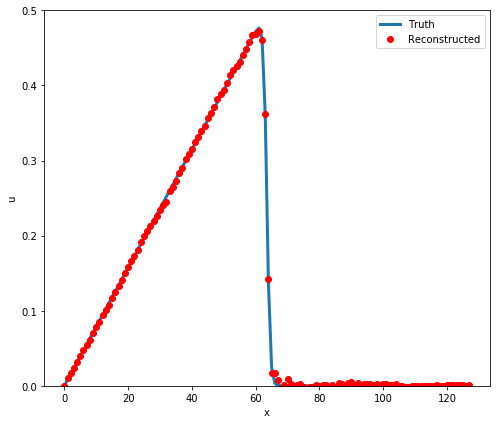

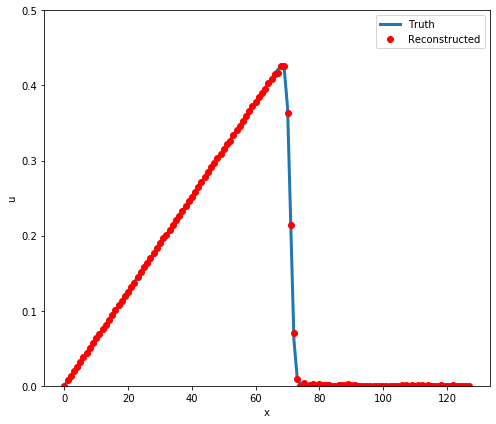

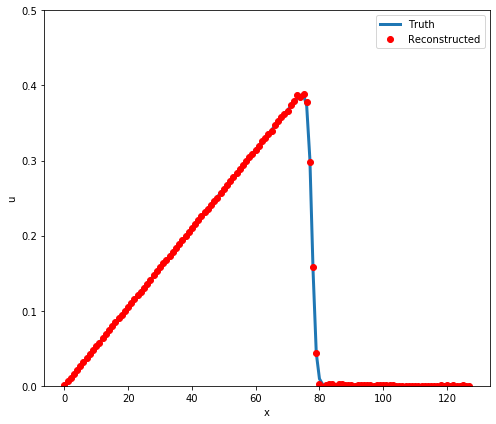

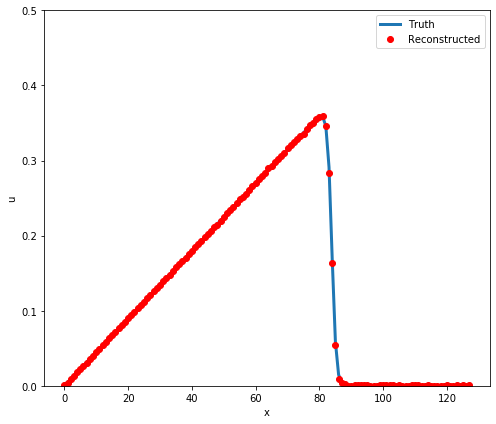

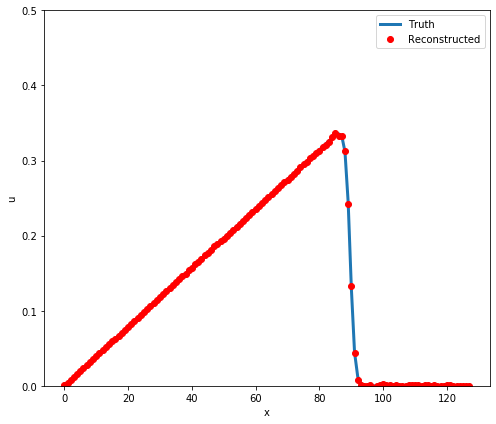

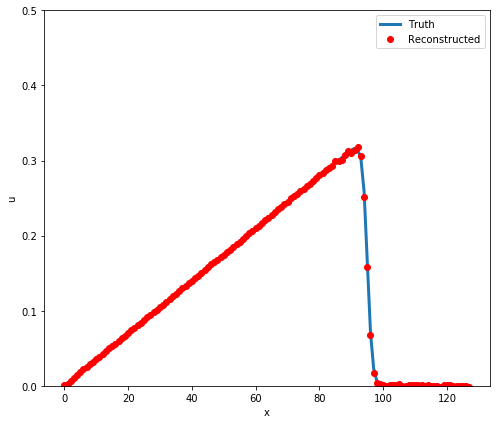

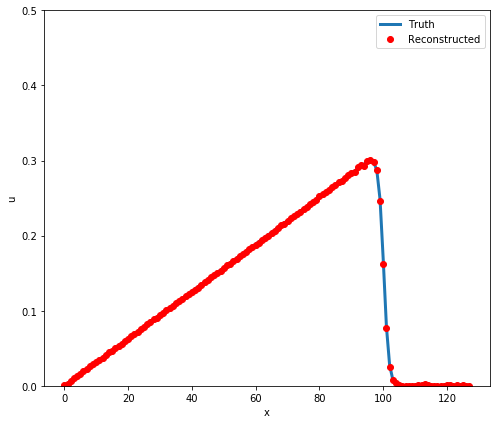

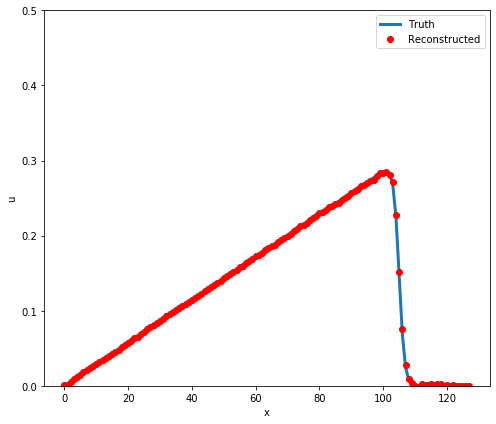

In [12]:
import matplotlib.pyplot as plt
model.load_weights(weights_filepath)
recoded_1 = model.predict(snapshots_train)[0]

for i in range(0,snapshots_train.shape[0],50):
    plt.figure(figsize=(7,6))
    plt.plot(snapshots_train[i,:,0:],label='Truth',linewidth=3)
    plt.plot(recoded_1[i,:,0:],'ro',label='Reconstructed')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.ylim((0,0.5))
    plt.tight_layout()
    plt.legend()
    plt.show()

### Check accuracy of Autoencoder+LSTM

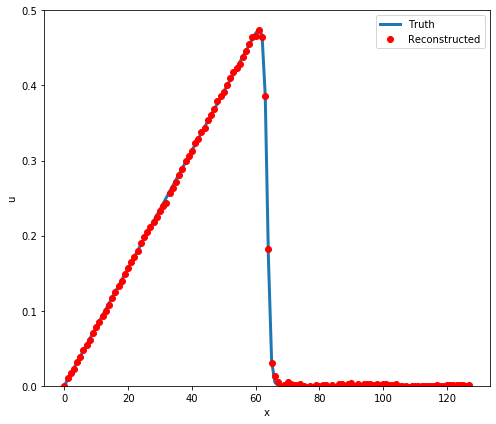

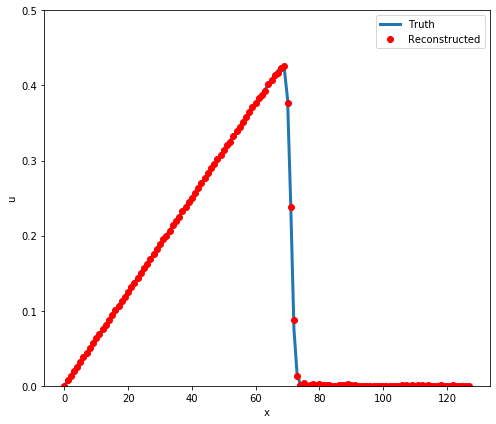

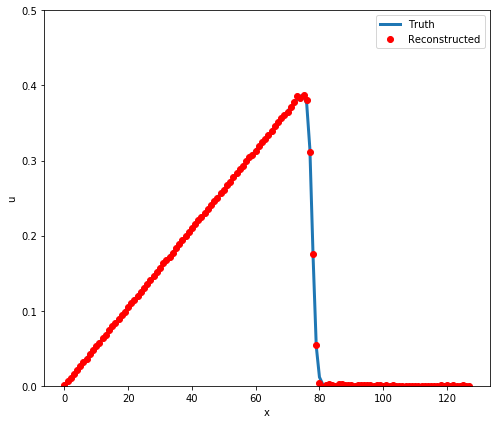

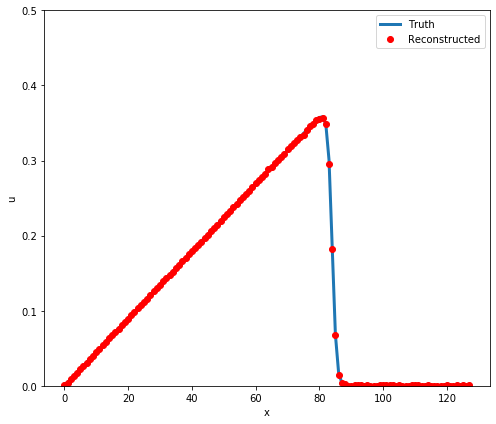

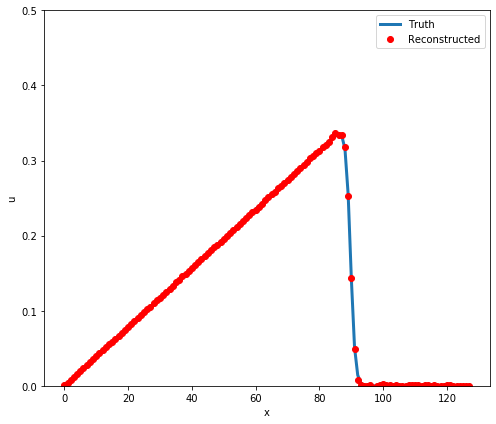

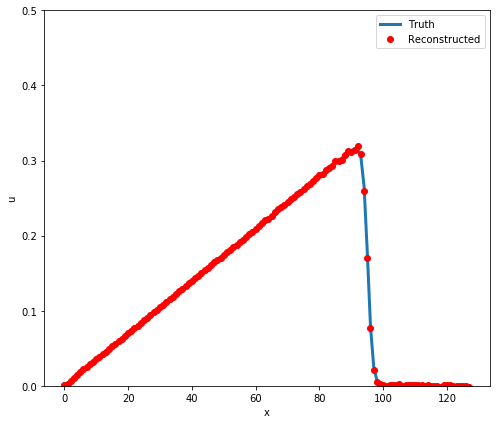

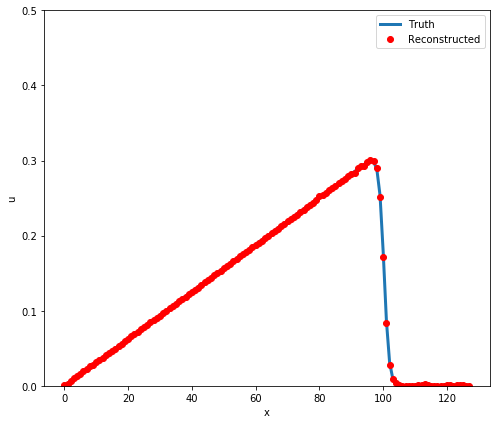

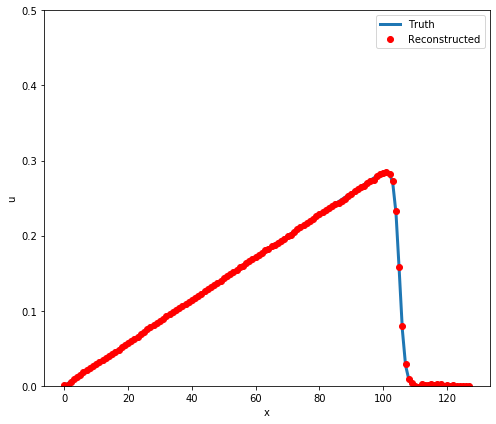

In [9]:
import matplotlib.pyplot as plt
model.load_weights(weights_filepath)
recoded_1 = model.predict(snapshots_train)[1]

for i in range(0,snapshots_train.shape[0],50):
    plt.figure(figsize=(7,6))
    plt.plot(snapshots_train[i+1,:,0:],label='Truth',linewidth=3)
    plt.plot(recoded_1[i,:,0:],'ro',label='Reconstructed')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.ylim((0,0.5))
    plt.tight_layout()
    plt.legend()
    plt.show()

### Get encoded representation

In [10]:
get_latent_representation = K.function([model.layers[0].input],
                                  [model.layers[12].output]) # Layer number 10 is the MaxPooling2D before entry to LSTM
layer_output = get_latent_representation([snapshots_train])[0]

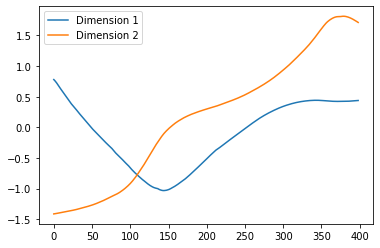

In [11]:
plt.figure()
plt.plot(layer_output[:,0],label='Dimension 1')
plt.plot(layer_output[:,1],label='Dimension 2')
plt.legend()
plt.show()

In [14]:
np.save('Latent.npy',layer_output)